<a href="https://colab.research.google.com/github/htapiagroup/sistdist/blob/master/MCA_SDU_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos y Ubicuos II
## MCA Tercer cuatrimestre
### Horacio Tapia-McClung

## Resumen Semana 5

* arreglos multidimensionales con `numpy` y `dask`
* DataFrames con `pandas` y `dask`

* leyendo multiples archivos de texto (.csv)
* construyendo flujos retrasados
* cronometraje de operaciones con dataframes, `pandas` vs. `dask`

Cuando usar `pandas` y cuando usar `dask`?

In [122]:
[k for k in range(1,2)]

[1]

# Analizando los viajes en taxi de la Ciudad de NY

In [0]:
# download taxi data

import os
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla
urls = (plantillaURL.format(k) for k in range(1,13)) # generator
for url in urls:
  os.system(url)

In [0]:
ls

sample_data/                 yellow_tripdata_2018-07.csv
yellow_tripdata_2018-01.csv  yellow_tripdata_2018-08.csv
yellow_tripdata_2018-02.csv  yellow_tripdata_2018-09.csv
yellow_tripdata_2018-03.csv  yellow_tripdata_2018-10.csv
yellow_tripdata_2018-04.csv  yellow_tripdata_2018-11.csv
yellow_tripdata_2018-05.csv  yellow_tripdata_2018-12.csv
yellow_tripdata_2018-06.csv


In [0]:
%ll -h yellow_tripdata_2018-*.csv

-rw-r--r-- 1 root 737M Aug  3  2018 yellow_tripdata_2018-01.csv
-rw-r--r-- 1 root 715M Aug  3  2018 yellow_tripdata_2018-02.csv
-rw-r--r-- 1 root 794M Aug  3  2018 yellow_tripdata_2018-03.csv
-rw-r--r-- 1 root 784M Aug  3  2018 yellow_tripdata_2018-04.csv
-rw-r--r-- 1 root 777M Aug  3  2018 yellow_tripdata_2018-05.csv
-rw-r--r-- 1 root 734M Aug  3  2018 yellow_tripdata_2018-06.csv
-rw-r--r-- 1 root 661M Feb  5 15:07 yellow_tripdata_2018-07.csv
-rw-r--r-- 1 root 661M Feb  5 15:09 yellow_tripdata_2018-08.csv
-rw-r--r-- 1 root 678M Feb  5 15:12 yellow_tripdata_2018-09.csv
-rw-r--r-- 1 root 744M Feb  5 15:14 yellow_tripdata_2018-10.csv
-rw-r--r-- 1 root 687M Feb  5 15:16 yellow_tripdata_2018-11.csv
-rw-r--r-- 1 root 689M Feb  5 15:19 yellow_tripdata_2018-12.csv


In [0]:
import pandas as pd
import numpy as np

In [124]:
df = pd.read_csv('yellow_tripdata_2018-01.csv')
df.shape

(8759874, 17)

In [125]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

In [126]:
df['payment_type'].value_counts()

1    6105871
2    2598947
3      43204
4      11852
Name: payment_type, dtype: int64

# Using `pandas`

In [0]:
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

In [0]:
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [0]:
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

In [0]:
# Filter rows where payment_type == 1: credit
credit = df[df.payment_type==1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))
print(result)

<class 'pandas.core.series.Series'>


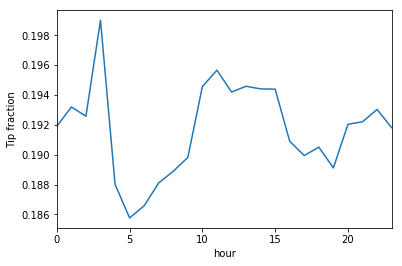

In [133]:
import matplotlib.pyplot as plt
# Perform the computation
tip_frac = result

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()

# Using `dask`

## Reading & cleaning files

Here you'll be working with a subset of the NYC Taxi Trip data. The first step is to use the Dask dd.read_csv() function to read multiple files at once. Dask will automatically concatenate the contents of the files into a single DataFrame. Notice that you'll use the option assume_missing=True in the call to dd.read_csv() to suppress warning messages.

Your job is to use a glob pattern containing the * character to read all of the CSV files from the taxi/ subdirectory into a single Dask DataFrame. You'll then construct a new column called 'tip_fraction' using the 'tip_amount' and 'total_amount' columns. The 'total_amount' is the sum of the fare, other fees, and the tip_amount.

## Instrucciones


 * Read all .csv files from the taxi/ directory (with a wildcard pattern *).
 * Create a column 'tip_fraction', which is the result of the 'tip_amount' divided by the difference of the 'total_amount' and 'tip_amount' columns.
 * Convert the 'tpep_dropoff_datetime' column to datetime using dd.to_datetime().
 * Create a column 'hour' using the .dt.hour attribute of the 'tpep_dropoff_datetime' column.


In [0]:
import dask.dataframe as dd
# Read all .csv files: df
df = dd.read_csv('taxi/yellow*.csv', assume_missing=True)

# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

## Filtering & grouping data

You have the Dask dataframe df prepared using multiple CSV files from the last exercise. It contains a subset of the 2015 yellow taxi ride data from New York City with some additional columns from preprocessing. Remember, none of the files have actually been loaded, nor has any computation been done to construct the new columns.

Your task now is to build a pipeline of computations to compute the hourly average tip fraction for each hour of the day across the entire year of data. You'll have to filter for payments of type 1 (credit card transactions) from the 'payment_type' column, group transactions using the 'hour' column, and finally aggregate the mean from the 'tip_fraction' column.

## Instrucciones

* Filter out rows where payment_type is 1 and call the resulting dataframe credit.
* Group credit using the 'hour' column and call the result 'hourly'.
* Select the 'tip_fraction' column and aggregate the mean.
* Display the data type of result.


In [0]:
# Filter rows where payment_type == 1: credit
credit = df[df.payment_type==1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))

## Computing & plotting

Now that you've got the entire delayed pipeline prepared it's time compute and plot the result. Matplotlib has been imported for you as plt.

Warning: The execution of of this exercise is expected to be several seconds.

## Instrucciones


* Perform the computation on result and assign it to tip_frac.
* Print the type of tip_frac.
* Hit 'Submit Answer to view the plot.


In [0]:
import matplotlib.pyplot as plt
# Perform the computation
tip_frac = result.compute()

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()

# Exploratory data analysis using `pandas` on a single file with all the 2015 data

homework will be using `dask`

In [0]:
!wget http://s3.amazonaws.com/datashader-data/nyc_taxi.zip && unzip nyc_taxi.zip 

In [134]:
import pandas as pd
%time df = pd.read_csv('nyc_taxi.csv',usecols=['pickup_x', 'pickup_y', 'dropoff_x','dropoff_y', 'passenger_count','tpep_pickup_datetime','tpep_dropoff_datetime','tip_amount','total_amount'], parse_dates=[0, 1])
df.tail()

KeyboardInterrupt: ignored

## A simple plot

In [0]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show

NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

options = dict(line_color=None, fill_color='blue', size=5)

In [99]:
%%time
from bokeh.tile_providers import STAMEN_TERRAIN

output_notebook()

samples = df.sample(n=1000)
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=samples['dropoff_x'], y=samples['dropoff_y'], **options)
show(p)

Loading BokehJS ...

CPU times: user 705 ms, sys: 23.1 ms, total: 728 ms
Wall time: 737 ms


## A simple analysis

In [103]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y'],
      dtype='object')

In [0]:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds

In [0]:
is_long_trip = df.duration > 1200

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10679307 entries, 0 to 10679306
Data columns (total 8 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
pickup_x                 float64
pickup_y                 float64
dropoff_x                float64
dropoff_y                float64
duration                 int64
dtypes: datetime64[ns](2), float64(4), int64(2)
memory usage: 651.8 MB


In [0]:
samples = df.sample(n=10000)

In [116]:
is_long_trip = samples.duration > 1200
df_samples = samples.loc[is_long_trip]
df_samples.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_x,pickup_y,dropoff_x,dropoff_y,duration
9516580,2015-01-19 23:21:20,2015-01-19 23:43:37,1,-8.235118e+06,4.981072e+06,-8.235544e+06,4.971283e+06,1337
6218641,2015-01-25 14:08:35,2015-01-25 14:31:47,1,-8.237808e+06,4.976518e+06,-8.235308e+06,4.977272e+06,1392
4666262,2015-01-14 19:34:42,2015-01-14 19:57:01,2,-8.235831e+06,4.978192e+06,-8.238333e+06,4.969141e+06,1339
2285166,2015-01-29 09:58:46,2015-01-29 10:18:51,1,-8.234586e+06,4.974817e+06,-8.235271e+06,4.977220e+06,1205
5829128,2015-01-22 23:40:23,2015-01-23 00:17:08,1,-8.235342e+06,4.974669e+06,-8.235272e+06,4.970199e+06,2205


In [117]:
df_samples['passenger_count'].sum()

1460

In [118]:
!head nyc_taxi.csv

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,store_and_fwd_flag,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-8236962.87845,4975552.61692,1,N,-8234835.38116,4975627.16997,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.3,-8237825.76757,4971752.28598,1,N,-8237020.63087,4976875.03705,1,14.5,0.5,0.5,2.0,0.0,0.3,17.8
1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.5,-8238653.83538,4970221.02621,1,N,-8238123.87198,4971126.9786,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8
1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.0,-8234433.66211,4977362.79122,1,N,-8238107.73527,4974456.80877,2,15.0,0.5,0.5,0.0,0.0,0.3,16.3
1,2015-01-10 20:33:39,2015-01-10 20:58:31,1,2.2,-8235780.65241,4972011.72183,1,N,-8236804.05929,4975482.54878,2,14.0,0.5,0.5,0.0,0.0,0.3,15.3
1,2015-01-10 20:33:39,2015-01-10 20:42:20,

In [0]:
# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour